# 2.1 Web Services

In [1]:
import requests

In [2]:
result = requests.get("http://cat-fact.herokuapp.com/facts/random")

In [3]:
print(result)

<Response [200]>


In [4]:
print(result.json())

{'used': False, 'source': 'api', 'type': 'cat', 'deleted': False, '_id': '591f98703b90f7150a19c134', '__v': 0, 'text': 'Statistics indicate that animal lovers in recent years have shown a preference for cats over dogs!', 'updatedAt': '2020-05-10T20:20:11.457Z', 'createdAt': '2018-01-04T01:10:54.673Z', 'status': {'verified': True, 'sentCount': 1}, 'user': '5a9ac18c7478810ea6c06381'}


In [5]:
print(result.json()['text'])

Statistics indicate that animal lovers in recent years have shown a preference for cats over dogs!


## Echo Service

Instead of running this in a Jupyter notebook, we’ll save the script as a file called echo.py.

In [6]:
!cat echo.py

# load Flask 
import flask
app = flask.Flask(__name__)

# define a predict function as an endpoint 
@app.route("/", methods=["GET","POST"])
def predict():
    data = {"success": False}
    
    # check for passed in parameters   
    params = flask.request.json
    if params is None:
        params = flask.request.args
    
    # if parameters are found, echo the msg parameter 
    if "msg" in params.keys(): 
        data["response"] = params.get("msg")
        data["success"] = True
        
    # return a response in json format 
    return flask.jsonify(data)
    
# start the flask app, allow remote connections
if __name__ == '__main__':
    app.run(host='0.0.0.0')


## Call the Service

In [7]:
import os
import requests

In [8]:
HOST = os.environ['HOSTNAME']

In [9]:
result = requests.get(url=f"http://{HOST}:5000/")
print(result.json())

{'success': False}


In [10]:
result = requests.get(url=f"http://{HOST}:5000/?msg=Hello from URL!")
print(result.json())

{'response': 'Hello from URL!', 'success': True}


In [11]:
result = requests.get(url=f"http://{HOST}:5000/",
                      params={'msg': 'Hello from params'})
print(result.json())

{'response': 'Hello from params', 'success': True}


In [12]:
result = requests.post(url=f"http://{HOST}:5000/",
                       json={ 'msg': 'Hello from data'})
print(result.json())

{'response': 'Hello from data', 'success': True}


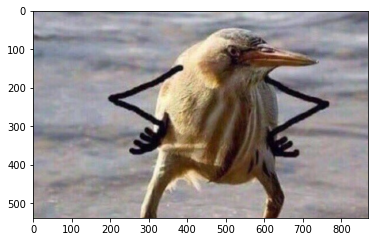

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import io
import base64

HOST = 'localhost'

image = open("../ignore/meme.jpg", "rb").read()
encoded = base64.b64encode(image)
result = requests.get(url=f"http://{HOST}:5000/", 
                      json={'msg': encoded})

encoded = result.json()['response']
imgData = base64.b64decode(encoded)
plt.imshow(np.array(Image.open(io.BytesIO(imgData))))
plt.show()

# 2.2 Model Persistence

In [7]:
import pandas as pd
from sklearn.linear_model import LogisticRegression

df = pd.read_csv("https://github.com/bgweber/Twitch/raw/master/Recommendations/games-expand.csv")
x = df.drop(['label'], axis=1)
y = df['label']

model = LogisticRegression()
model.fit(x, y)


/home/ec2-user/.local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [16]:
import pickle
pickle.dump(model, open("logit.pkl", 'wb'))

model = pickle.load(open("logit.pkl", 'rb'))
model.predict_proba(x)


array([[0.93108997, 0.06891003],
       [0.86467   , 0.13533   ],
       [0.85753053, 0.14246947],
       ...,
       [0.89944263, 0.10055737],
       [0.85753053, 0.14246947],
       [0.89944263, 0.10055737]])

# ML Flow

In [8]:
import mlflow
import mlflow.sklearn
import shutil

model_path = "models/logit_games_v1"
shutil.rmtree(model_path)
mlflow.sklearn.save_model(model, model_path)

loaded = mlflow.sklearn.load_model(model_path)
loaded.predict_proba(x)


array([[0.93108997, 0.06891003],
       [0.86467   , 0.13533   ],
       [0.85753053, 0.14246947],
       ...,
       [0.89944263, 0.10055737],
       [0.85753053, 0.14246947],
       [0.89944263, 0.10055737]])

In [9]:
import tensorflow as tf
import keras
from keras import models, layers


# define the network structure 
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10,)))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

# define ROC AUC as a metric 
def auc(y_true, y_pred):
    auc = tf.metrics.auc(y_true, y_pred)[1]
    keras.backend.get_session().run(
                  tf.local_variables_initializer())
    return auc
    
# compile and fit the model    
model.compile(optimizer='rmsprop',
                 loss='binary_crossentropy', metrics=[auc])
history = model.fit(x, y, epochs=100, batch_size=100, 
                 validation_split = .2, verbose=0)


/home/ec2-user/.local/lib/python3.7/site-packages/tensorflow/python/util/nest.py:1286: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  _pywrap_tensorflow.RegisterType("Mapping", _collections.Mapping)
/home/ec2-user/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ec2-user/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ec2-user/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:5

In [11]:
from keras.models import load_model
model.save("games.h5")

model = load_model('games.h5', custom_objects={'auc': auc})
model.evaluate(x, y, verbose = 0)


[0.30503726916928864, 0.8148908399801748]

In [15]:
import mlflow.keras

model_path = "models/keras_games_v1"
mlflow.keras.save_model(model, model_path)

loaded = mlflow.keras.load_model(model_path, custom_objects={'auc': auc})
loaded.evaluate(x, y, verbose = 0)


[0.30503726916928864, 0.8148908399801748]

# scikit-learn endpoint

In [6]:

import pandas as pd
from sklearn.linear_model import LogisticRegression
import mlflow
import mlflow.sklearn
import flask

model_path = "models/logit_games_v1"
model  = mlflow.sklearn.load_model(model_path)

app = flask.Flask(__name__)

@app.route("/", methods=["GET","POST"])
def predict():
    data = {"success": False}
    params = flask.request.args

    if "G1" in params.keys(): 
        new_row = { "G1": params.get("G1"), "G2": params.get("G2"), 
                    "G3": params.get("G3"), "G4": params.get("G4"), 
                    "G5": params.get("G5"), "G6": params.get("G6"), 
                    "G7": params.get("G7"), "G8": params.get("G8"), 
                    "G9": params.get("G9"), "G10": params.get("G10") }

        new_x = pd.DataFrame.from_dict(new_row, orient = "index").transpose()                
        data["response"] = str(model.predict_proba(new_x)[0][1])
        data["success"] = True

    return flask.jsonify(data)

if __name__ == '__main__':
    app.run(host='0.0.0.0')


 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://0.0.0.0:5000/ (Press CTRL+C to quit)


In [12]:
import requests

new_row = { "G1": 0, "G2": 0, "G3": 0, "G4": 0, "G5": 0,
            "G6": 0, "G7": 0, "G8": 0, "G9": 0, "G10": 1 }

result = requests.get("http://52.90.199.190:5000/", params=new_row)
print(result.json()['response'])


0.32732567


# Keras Endpoint

In [2]:

import pandas as pd
import mlflow
import mlflow.keras
import flask
import tensorflow as tf
import keras as k

def auc(y_true, y_pred):
    auc = tf.metrics.auc(y_true, y_pred)[1]
    k.backend.get_session().run(
                  tf.local_variables_initializer())
    return auc

global graph
graph = tf.get_default_graph()
model_path = "models/keras_games_v1"
model = mlflow.keras.load_model(model_path, custom_objects={'auc': auc})

app = flask.Flask(__name__)

@app.route("/", methods=["GET","POST"])
def predict():
    data = {"success": False}
    params = flask.request.args

    if "G1" in params.keys(): 
        new_row = { "G1": params.get("G1"), "G2": params.get("G2"), 
                    "G3": params.get("G3"), "G4": params.get("G4"), 
                    "G5": params.get("G5"), "G6": params.get("G6"), 
                    "G7": params.get("G7"), "G8": params.get("G8"), 
                    "G9": params.get("G9"), "G10": params.get("G10") }

        new_x = pd.DataFrame.from_dict(new_row, orient = "index").transpose()                

        with graph.as_default():        
            data["response"] = str(model.predict(new_x)[0][0])
            data["success"] = True

    return flask.jsonify(data)

#if __name__ == '__main__':
#    app.run(host='0.0.0.0')

# Dash

In [7]:
import pandas as pd
import mlflow.sklearn


model_path = "models/logit_games_v1"
model  = mlflow.sklearn.load_model(model_path)


def update_prediction(game1, game2):

    new_row = { "G1": float(game1), "G2": float(game2), 
                "G3": 0, "G4": 0, 
                "G5": 0, "G6": 0, 
                "G7": 0, "G8": 0, 
                "G9": 0, "G10":0 }

    new_x = pd.DataFrame.from_dict(new_row, orient = "index").transpose()                
    return str(model.predict_proba(new_x)[0][1])    

update_prediction(1, 0)


'0.06745113592634559'

# Call the Heroku 

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import io
import base64
import requests

image = open("luna.png", "rb").read()
encoded = base64.b64encode(image)

result = requests.get("https://obscure-coast-69593.herokuapp.com/echo", params = {'msg': encoded})
result

#encoded = result.json()['response']
#imgData = base64.b64decode(encoded)
#plt.imshow( np.array(Image.open(io.BytesIO(imgData)) ))



<Response [414]>

In [2]:
import requests
result = requests.get("https://obscure-coast-69593.herokuapp.com",  
                      params = { 'msg': 'Hello from Heroku Prod' })
print(result.json())


{'response': 'Hello from Heroku Prod', 'success': True}
